In [1]:
import xarray as xr
import csv
import pandas as pd
import numpy as np
import os
import pickle as pkl
from datetime import datetime, date, timedelta
import sys
import matplotlib.pyplot as plt
import netCDF4 as nc
import glob

In [2]:
# Open daily files with HYCOM near TCs

In [3]:
# define start and end years, and other parameters
# start_year = 2017
# end_year = 2017
var_names_download = ['temp', 'salt']
var_names = ['temperature', 'salinity']
HYCOM_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/DATA/HYCOM_near_TC_53x_pkl_Aug21/'
# HYCOM_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/DATA/HYCOM_near_TC_pkl_min20_plus20/'

tag_file = 'HYCOM_53X'

wind_threshold = 32.9244
precip_treshold = 0.0025

In [4]:
# # Test - open a single one
# f = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/DATA/HYCOM_near_TC_pkl/HYCOM_GBLa0.08_2009-01-01.pkl'
# ciao = pkl.load(open(f, "rb"))
# ciao

In [5]:
# List all files
files = [i for i in sorted(glob.glob(HYCOM_dir + 'HYCOM_*.pkl'))]
# Open and concatenate all files into a single xarray.Dataset
new_dict = xr.concat([pkl.load(open(f, "rb"))for f in files ], "index")
# Reset index 
new_dict['index'] = np.arange(0,new_dict.index.shape[0])


In [6]:
# Salinity at day -5, needed as the classification will be based on this variable
salinity_day_minus5 = new_dict.isel(delta_time = 0).salinity # index 5 corresponds to day -5

In [7]:
# # Determine percentage of profile depth levels where the variable value is larger than at the surface
# # Comparing each pressure levels with the one at the surface, then calculating the difference 
# # between each profile depth and the surface one:
# # if >75% of the profiles have a positive difference -> increasing
# # otherwise -> decreasing
# perc_points_increasing_s = np.zeros(len(new_dict.index))
# perc_points_decreasing_s = np.zeros(len(new_dict.index))
# perc_points_same_s = np.zeros(len(new_dict.index))

In [8]:
# Find depth
dz_increasing = np.zeros(len(new_dict.index))
dz_decreasing = np.zeros(len(new_dict.index))
dz_dsame = np.zeros(len(new_dict.index))

dz = np.array([2,2,2,2,2,2.5,4,5,5,5,5,5,5,7.5,10,10,10,10,17.5,25,37.5,50,50,50,50,50,25]) # spessore per ogni livello di pressione
dz_star = dz[1:]
# Calculate increasing vs decreasing total meters
for i in np.arange(0,len(new_dict.index)):
    dz_increasing[i] = sum(dz[(salinity_day_minus5[1:,i].values-salinity_day_minus5[0,i].values)>0])
    dz_decreasing[i] = sum(dz[(salinity_day_minus5[1:,i].values-salinity_day_minus5[0,i].values)<0])
    dz_dsame[i] = sum(dz[(salinity_day_minus5[1:,i].values-salinity_day_minus5[0,i].values)==0])
    

In [9]:
# Create a DFS with increasing, decreasing, all
# se dz_increasing > dz_decreasing -> increasing; 
# altrimenti viceversa


DFS = [(new_dict.where((dz_increasing > dz_decreasing) & (new_dict.wind >= wind_threshold), drop = True), 'increasing_hurr_s'),
       (new_dict.where((dz_decreasing > dz_increasing) & (new_dict.wind >= wind_threshold), drop = True), 'decreasing_hurr_s'),
       (new_dict.where((dz_decreasing == dz_increasing) & (new_dict.wind >= wind_threshold), drop = True), 'same_hurr_s'),
       (new_dict.where(new_dict.wind >= wind_threshold, drop = True), 'all_hurr_s'),
       (new_dict.where((dz_increasing > dz_decreasing) & (new_dict.wind >= wind_threshold) & (new_dict.precipitation >= precip_treshold), drop = True), 'increasing_hurr_s_precip_ge'), # precipitation greater equal
       (new_dict.where((dz_decreasing > dz_increasing) & (new_dict.wind >= wind_threshold) & (new_dict.precipitation >= precip_treshold), drop = True), 'decreasing_hurr_s_precip_ge'),
       (new_dict.where((dz_increasing > dz_decreasing) & (new_dict.wind >= wind_threshold) & (new_dict.precipitation < precip_treshold), drop = True), 'increasing_hurr_s_precip_lt'), # precipitation less than
       (new_dict.where((dz_decreasing > dz_increasing) & (new_dict.wind >= wind_threshold) & (new_dict.precipitation < precip_treshold), drop = True), 'decreasing_hurr_s_precip_lt')      
      ]





In [10]:
# Distinguish arrays for each of the three cases (inc, dec, combined)
decreasing_hurr = DFS[1][0]#.iloc[:,3:].reset_index()
increasing_hurr = DFS[0][0]#.iloc[:,3:].reset_index()
all_hurr = DFS[3][0]#.iloc[:,3:].reset_index()
same_hurr = DFS[2][0]
increasing_hurr_s_precip_ge = DFS[4][0]
decreasing_hurr_s_precip_ge = DFS[5][0]
increasing_hurr_s_precip_lt = DFS[6][0]
decreasing_hurr_s_precip_lt = DFS[7][0]

print(np.shape(decreasing_hurr.index))
print(np.shape(increasing_hurr.index))
print(np.shape(all_hurr.index))
print(np.shape(same_hurr.index))
print(np.shape(increasing_hurr_s_precip_ge.index))
print(np.shape(decreasing_hurr_s_precip_ge.index))
print(np.shape(increasing_hurr_s_precip_lt.index))
print(np.shape(decreasing_hurr_s_precip_lt.index))

(4026,)
(43841,)
(48242,)
(375,)
(23879,)
(2139,)
(19962,)
(1887,)


In [ ]:
# Create function that calculates the number of profile pairs that 

In [ ]:
# # Classify "profiles" based on day -5 salinity
# for i in np.arange(0,len(new_dict.index)):
#             # Separates increasing and decreasing profile pairs    
#     perc_points_increasing_s[i] = (sum((salinity_day_minus5[:,i]
#                                       -salinity_day_minus5[0,i])>0)
#                                  /len(salinity_day_minus5[:,i])*100)
#     perc_points_decreasing_s[i] = (sum((salinity_day_minus5[:,i]
#                                       -salinity_day_minus5[0,i])<0)
#                                  /len(salinity_day_minus5[:,i])*100)
#     perc_points_same_s[i] = (sum((salinity_day_minus5[:,i]
#                                       -salinity_day_minus5[0,i])==0)
#                                  /len(salinity_day_minus5[:,i])*100)
#     # E.g., 'Increasing' = profiles where at least 75% of the depth levels have VAR values higher than at the surface

In [ ]:
# # Create a DFS with increasing, decreasing, all
# DFS = [(new_dict.where((perc_points_decreasing_s > 40) & (new_dict.wind >= 64), drop = True), 'decreasing_hurr_s'),
#        (new_dict.where((perc_points_increasing_s > 40) & (new_dict.wind >= 64), drop = True), 'increasing_hurr_s'),
#        (new_dict.where(new_dict.wind >= 64, drop = True), 'all_hurr_s')]

# # Save DFS
# #pkl.dump(DFS, open('DFS_HYCOM.pkl', 'wb'))


In [ ]:
# # Distinguish arrays for each of the three cases (inc, dec, combined)
# decreasing_hurr = DFS[0][0]#.iloc[:,3:].reset_index()
# increasing_hurr = DFS[1][0]#.iloc[:,3:].reset_index()
# all_hurr = DFS[2][0]#.iloc[:,3:].reset_index()

In [ ]:
# decreasing_hurr

In [ ]:
# increasing_hurr

In [ ]:
# all_hurr

In [11]:
# timestep_list = [-20, -15, -12 ,-10, -7, -5, -2, 0, 2, 5, 7, 10, 12, 15, 20]
timestep_list = [-5, -2, 0, 2, 5]

# Dictionaries to store temperature/salinity data at the various timestamps
variable_names = ['increasing_hurr', 'decreasing_hurr', 'increasing_hurr_s_precip_ge',\
                 'decreasing_hurr_s_precip_ge', 'increasing_hurr_s_precip_lt', 'decreasing_hurr_s_precip_lt']
ts_names = ['temperature', 'salinity']

for i in variable_names:
    for j in ts_names:
        exec(i + "_" + j[0] + " = {}")
        for i_day in np.arange(len(timestep_list)):
            exec(i + "_" + j[0] + "[timestep_list[i_day]] = " + i + ".isel(delta_time = i_day)." + j)
               
        

In [12]:
def hist_plot(sel_difference, depth_index, variable, case, day_earlier, day_later):
    fig, ax = plt.subplots()#(figsize = (6,4))
    plt.hist(sel_difference.values[depth_index,:], bins=np.arange(-1,1,.05))
    plt.vlines(x=0, ymin=0, ymax=max(ax.get_ylim()), colors='k') # ax.get_ylim()
    plt.title(case + ' ' + variable + ' diff day ' + str(day_later) + ' and day ' + str(day_earlier) + ' at depth level ' + str(depth_index), fontsize = 12)
    plt.xlabel(variable + ' difference', fontsize = 12)
    plt.ylabel('Count', fontsize = 12)

    print("Median =", np.nanmedian(sel_difference.values[depth_index,:]))
    print("Mean =", np.nanmean(sel_difference.values[depth_index,:]))
    print("St dev =", np.std(sel_difference.values[depth_index,:]))
    
    

In [20]:
# Select the desired case to plot
depth_index = 10 # indexes correspond to depths: 0, 10, 20, 30, 50, 75, 100, 125, 150, 200 m
# variable = 's' # s (salinity) or t (temperature)
# case = 'increasing_hurr'
day_earlier = -5
day_later = 5
ts_names_plot = ['salinity']

Median = 0.04080529741770178
Mean = 0.04150358997108569
St dev = nan
Median = -0.036009140990127975
Mean = -0.041901986323868594
St dev = nan
Median = 0.03879414959137506
Mean = 0.040257776100670634
St dev = nan
Median = -0.04663048354061061
Mean = -0.052895527901043814
St dev = nan
Median = 0.0431474156795133
Mean = 0.04299466698180893
St dev = nan
Median = -0.0250520614776768
Mean = -0.029337938807096915
St dev = nan


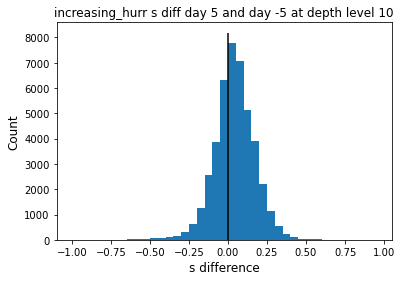

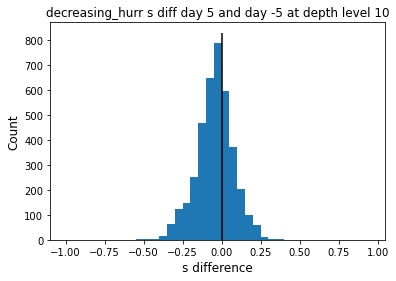

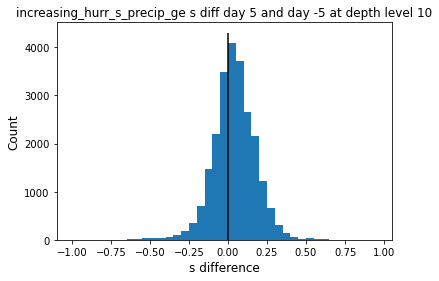

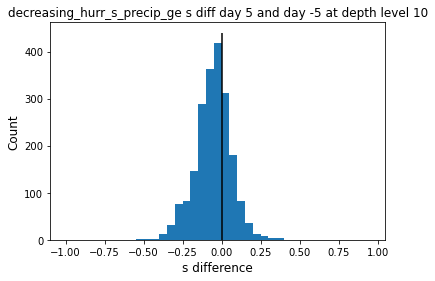

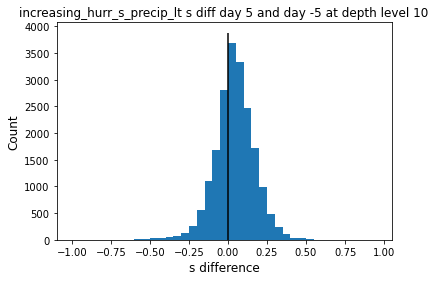

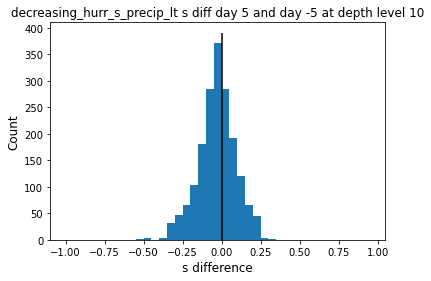

In [21]:
for i in variable_names:
    for j in ts_names_plot:
        exec("bfr =" + i + "_" + j[0])
        hist_plot(sel_difference = bfr[day_later] - bfr[day_earlier], depth_index = depth_index, \
                  variable = j[0], case = i, day_earlier = day_earlier, day_later = day_later)
        
        
        

In [15]:
# # Calculate the selected difference
# sel_difference = eval(variable + "_sel_days_" + case)[day_later] - eval(variable + "_sel_days_" + case)[day_earlier]


NameError: name 'variable' is not defined

In [ ]:
# Histogram for selected differences
plt.figure(figsize = (6,4))
plt.hist(sel_difference.values[depth_index,:], bins=np.arange(-1,1,.05))
plt.vlines(x=0, ymin=0, ymax=120, colors='k')
plt.title('Diff day ' + str(day_later) + ' and day ' + str(day_earlier) + ' at depth level ' + str(depth_index), fontsize = 12)
plt.xlabel(variable + ' difference', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

print("Median =", np.nanmedian(sel_difference.values[depth_index,:]))
print("Mean =", np.nanmean(sel_difference.values[depth_index,:]))
print("St dev =", np.std(sel_difference.values[depth_index,:]))



In [ ]:
# Now plot the mean difference vs depth

# Again, select the desired case
variable = 'salinity'
case = 'increasing'
day_earlier = -5
day_later = 5

# Calculate the mean difference at each depth
sel_difference = eval(variable + "_sel_days_" + case)[day_later] - eval(variable + "_sel_days_" + case)[day_earlier]
mean_diff_z = np.zeros(new_dict.depth.shape[0])
for depth_index in np.arange(new_dict.depth.shape[0]):
    mean_diff_z[depth_index] = np.nanmean(sel_difference.values[depth_index,:])


depth = new_dict.depth
# Plot of mean difference with depth
plt.figure(figsize = (6,6))
plt.plot(mean_diff_z,depth)
plt.vlines(x=0, ymin=0, ymax=500, colors='k', linewidth = 1, linestyle = '--')
plt.xlabel('Mean ' + variable + ' change', fontsize = 12)
plt.ylabel('Depth [m]', fontsize = 12)
plt.gca().invert_yaxis()
plt.title('Mean difference between day ' + str(day_later) + ' and day ' + str(day_earlier), fontsize = 12)

In [ ]:
# BELOW NEEDS TO BE UPDATED TO WORK WITH NEW VARIABLE STRUCTURE

In [ ]:
# Plot examples for single events - salinity case
sel_event = 232

plt.figure(figsize = (6,6))
plt.plot(salinity_day_minus5_inc.values[:,sel_event],salinity_day_minus5_inc.depth.values, label = 'Day -5')
plt.plot(salinity_day_0_inc.values[:,sel_event],salinity_day_minus5_inc.depth.values, label = 'Day 0')
plt.plot(salinity_day_plus5_inc.values[:,sel_event],salinity_day_minus5_inc.depth.values, label = 'Day +5')
plt.xlabel('Salinity (psu)', fontsize = 12)
plt.ylabel('Depth [m]', fontsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)

In [ ]:
# Plot examples for single events - temperature case
sel_event = 232

plt.figure(figsize = (6,6))
plt.plot(temperature_day_minus5_inc.values[:,sel_event],temperature_day_minus5_inc.depth.values, label = 'Day -5')
plt.plot(temperature_day_0_inc.values[:,sel_event],temperature_day_minus5_inc.depth.values, label = 'Day 0')
plt.plot(temperature_day_plus5_inc.values[:,sel_event],temperature_day_minus5_inc.depth.values, label = 'Day +5')
plt.xlabel('Temperature (deg C)', fontsize = 12)
plt.ylabel('Depth [m]', fontsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)

In [ ]:
salinity_avg_minus5_inc = salinity_day_minus5_inc.mean(dim='index')
salinity_avg_0_inc = salinity_day_0_inc.mean(dim='index')
salinity_avg_plus5_inc = salinity_day_plus5_inc.mean(dim='index')
salinity_avg_minus5_dec = salinity_day_minus5_dec.mean(dim='index')
salinity_avg_0_dec = salinity_day_0_dec.mean(dim='index')
salinity_avg_plus5_dec = salinity_day_plus5_dec.mean(dim='index')

In [ ]:
temperature_avg_minus5_inc = temperature_day_minus5_inc.mean(dim='index')
temperature_avg_0_inc = temperature_day_0_inc.mean(dim='index')
temperature_avg_plus5_inc = temperature_day_plus5_inc.mean(dim='index')
temperature_avg_minus5_dec = temperature_day_minus5_dec.mean(dim='index')
temperature_avg_0_dec = temperature_day_0_dec.mean(dim='index')
temperature_avg_plus5_dec = temperature_day_plus5_dec.mean(dim='index')

In [ ]:
# Plot average salinity values at -5, 0 and 5 days
plt.figure(figsize = (15,6))
plt.plot(salinity_avg_plus5_inc,temperature_day_minus5_inc.depth.values, label = 'avg S @ Day -5')
plt.plot(salinity_avg_minus5_inc,temperature_day_minus5_inc.depth.values, label = 'avg S @ Day 0')
plt.plot(salinity_avg_0_inc,temperature_day_minus5_inc.depth.values, label = 'avg S @ Day +5')
plt.xlabel('Salinity (psu)', fontsize = 12)
plt.ylabel('Depth [m]', fontsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)



In [ ]:
# Plot average temperature values at -5, 0 and 5 days
plt.figure(figsize = (15,6))
plt.plot(temperature_avg_plus5_inc,temperature_day_minus5_inc.depth.values, label = 'avg S @ Day -5')
plt.plot(temperature_avg_minus5_inc,temperature_day_minus5_inc.depth.values, label = 'avg S @ Day 0')
plt.plot(temperature_avg_0_inc,temperature_day_minus5_inc.depth.values, label = 'avg S @ Day +5')
plt.xlabel('Temperature (deg C)', fontsize = 12)
plt.ylabel('Depth [m]', fontsize = 12)
plt.gca().invert_yaxis()
plt.legend(fontsize = 12)